<a href="https://colab.research.google.com/github/MrFlamboyyandt/analyse_hackathon/blob/master/Zindi_Fraud_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from catboost import Pool, CatBoostClassifier, cv
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [0]:
!pip install catboost


     |████████████████████████████████| 61.2MB 583kB/s 


In [0]:
var_defs = pd.read_csv('Xente_Variable_Definitions.csv')

Looking at Variable Definitions

In [0]:
var_defs

,Column Name,Definition
0,TransactionId,Unique �transaction identifier on platform
1,BatchId,Unique number assigned to a batch of transacti...
2,AccountId,Unique number identifying the customer on plat...
3,SubscriptionId,Unique number identifying the customer subscri...
4,CustomerId,Unique identifier attached to Account
5,CurrencyCode,Country currency
6,CountryCode,Numerical geographical code of country
7,ProviderId,Source provider of Item �bought.
8,ProductId,Item name being bought.
9,ProductCategory,ProductIds are organized into these broader pr...


In [0]:
train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')

In [231]:
def get_unique_count(df):
  # function to count number of unique values in columns.
  # returns dictionary with column names and corresponding unique count.
  
  keys = list(df.columns)
  values = []
  
  for col in df.columns:
    
    uniq = df[col].nunique()
    values.append(uniq)
    
    print('Number of unique values in {}: {}'.format(str(col), uniq))
    
  return dict(zip(keys,values))

def drop_useless_cols(df, col_dict):
  # function to drop columns with only one unique value, i.e. no variance.
  # returns modified dataframe
  
  keys = list(col_dict.keys())
  kill_list = []
  
  for key in keys:
    if col_dict[key] == 1:
      kill_list.append(key)
    
    else:
      continue
      
  return df.drop(kill_list, axis=1)

col_uniq = get_unique_count(train)

train = drop_useless_cols(train, col_uniq)

Number of unique values in TransactionId: 95662
Number of unique values in BatchId: 94809
Number of unique values in AccountId: 3633
Number of unique values in SubscriptionId: 3627
Number of unique values in CustomerId: 3742
Number of unique values in CurrencyCode: 1
Number of unique values in CountryCode: 1
Number of unique values in ProviderId: 6
Number of unique values in ProductId: 23
Number of unique values in ProductCategory: 9
Number of unique values in ChannelId: 4
Number of unique values in Amount: 1676
Number of unique values in Value: 1517
Number of unique values in TransactionStartTime: 94556
Number of unique values in PricingStrategy: 4
Number of unique values in FraudResult: 2


In [233]:
uniq_test = get_unique_count(test)
test = drop_useless_cols(test, col_uniq)

Number of unique values in TransactionId: 45019
Number of unique values in BatchId: 44684
Number of unique values in AccountId: 2471
Number of unique values in SubscriptionId: 2470
Number of unique values in CustomerId: 5018
Number of unique values in CurrencyCode: 1
Number of unique values in CountryCode: 1
Number of unique values in ProviderId: 6
Number of unique values in ProductId: 26
Number of unique values in ProductCategory: 9
Number of unique values in ChannelId: 5
Number of unique values in Amount: 998
Number of unique values in Value: 944
Number of unique values in TransactionStartTime: 44018
Number of unique values in PricingStrategy: 4


In [0]:
# drop transaction ids from training set
transID = train['TransactionId']
train.drop('TransactionId', axis=1, inplace=True)

In [235]:
# quick calculation to check class imbalance
yes = train['FraudResult'].sum()
total = len(train['FraudResult'])
print('Percentage true: {}'.format((yes / total) * 100))

Percentage true: 0.20175200183981098


In [236]:
train.head()

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [0]:
y = train['FraudResult']
train.drop('FraudResult', axis=1, inplace=True)

In [0]:
train['TransactionStartTime'] = pd.to_datetime(train['TransactionStartTime'])

In [0]:
train['TransactionStartTime'] = train['TransactionStartTime'].apply(lambda x:x.toordinal())


In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
sc = StandardScaler()

In [0]:
train[['Amount', 'Value', 'TransactionStartTime']] = sc.fit_transform(train[['Amount', 'Value', 'TransactionStartTime']])

In [243]:
train.shape

(95662, 12)

In [0]:
test_id = test['TransactionId']
test.drop('TransactionId', axis=1, inplace=True)

In [0]:
test['TransactionStartTime'] = pd.to_datetime(test['TransactionStartTime'])
test['TransactionStartTime'] = test['TransactionStartTime'].apply(lambda x:x.toordinal())

In [0]:
test[['Amount', 'Value', 'TransactionStartTime']] = sc.transform(test[['Amount', 'Value', 'TransactionStartTime']])

In [247]:
test.shape

(45019, 12)

# Modeling

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, stratify=y)

In [0]:
categorical_features_indices = np.where(train.dtypes != np.float)[0]

In [0]:
clf = CatBoostClassifier(task_type='GPU', cat_features=categorical_features_indices, verbose=True)

In [0]:
clf = CatBoostClassifier(random_seed=42, custom_metric='F1')

In [254]:
clf.fit(X_train, y_train, cat_features=categorical_features_indices)
clf.score(X_test, y_test)

Learning rate set to 0.05718
0:	learn: 0.5321398	total: 119ms	remaining: 1m 59s
1:	learn: 0.4082049	total: 248ms	remaining: 2m 3s
2:	learn: 0.3140815	total: 362ms	remaining: 2m
3:	learn: 0.2158163	total: 513ms	remaining: 2m 7s
4:	learn: 0.1515829	total: 664ms	remaining: 2m 12s
5:	learn: 0.1037965	total: 867ms	remaining: 2m 23s
6:	learn: 0.0750924	total: 1.04s	remaining: 2m 28s
7:	learn: 0.0546928	total: 1.23s	remaining: 2m 33s
8:	learn: 0.0409979	total: 1.42s	remaining: 2m 36s
9:	learn: 0.0312014	total: 1.6s	remaining: 2m 38s
10:	learn: 0.0231546	total: 1.79s	remaining: 2m 41s
11:	learn: 0.0176406	total: 1.98s	remaining: 2m 43s
12:	learn: 0.0134315	total: 2.2s	remaining: 2m 46s
13:	learn: 0.0101828	total: 2.42s	remaining: 2m 50s
14:	learn: 0.0082010	total: 2.66s	remaining: 2m 54s
15:	learn: 0.0067482	total: 2.85s	remaining: 2m 55s
16:	learn: 0.0055504	total: 3.1s	remaining: 2m 59s
17:	learn: 0.0046471	total: 3.33s	remaining: 3m 1s
18:	learn: 0.0039847	total: 3.55s	remaining: 3m 3s
19:	

0.9993205456541054

In [255]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19094
           1       0.84      0.82      0.83        39

    accuracy                           1.00     19133
   macro avg       0.92      0.91      0.92     19133
weighted avg       1.00      1.00      1.00     19133



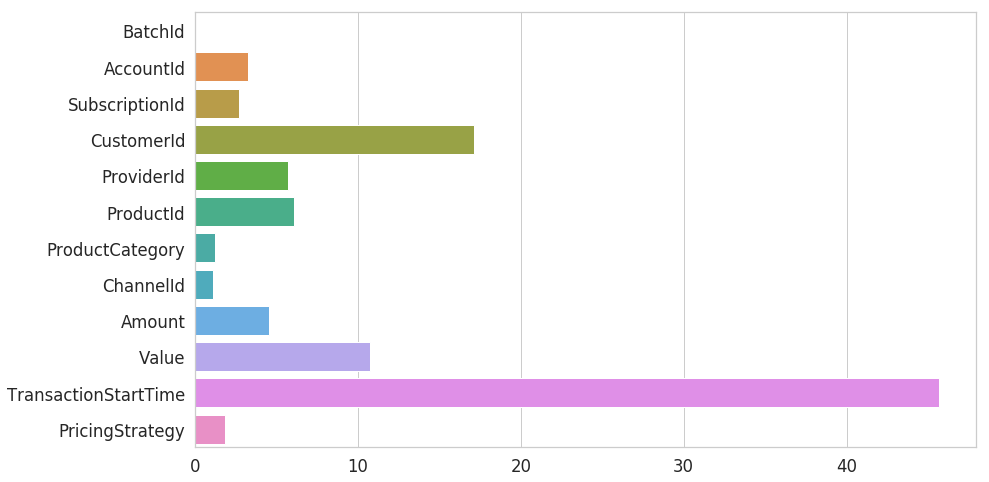

In [256]:
features = clf.feature_names_
importances = list(clf.feature_importances_)
sns.barplot(importances, features)

# Submission

In [0]:
clf_od = CatBoostClassifier(random_seed=42, od_type='Iter', od_wait=10, eval_metric='F1')

In [258]:
clf_od.fit(train, y, cat_features=categorical_features_indices)

Learning rate set to 0.060908
0:	learn: 0.0000000	total: 96.2ms	remaining: 1m 36s
1:	learn: 0.0000000	total: 236ms	remaining: 1m 57s
2:	learn: 0.0000000	total: 345ms	remaining: 1m 54s
3:	learn: 0.0000000	total: 411ms	remaining: 1m 42s
4:	learn: 0.0000000	total: 647ms	remaining: 2m 8s
5:	learn: 0.0000000	total: 815ms	remaining: 2m 15s
6:	learn: 0.0000000	total: 939ms	remaining: 2m 13s
7:	learn: 0.0000000	total: 1.17s	remaining: 2m 25s
8:	learn: 0.0000000	total: 1.4s	remaining: 2m 34s
9:	learn: 0.3290043	total: 1.69s	remaining: 2m 47s
10:	learn: 0.7133333	total: 1.95s	remaining: 2m 55s
11:	learn: 0.8377581	total: 2.24s	remaining: 3m 4s
12:	learn: 0.8454810	total: 2.49s	remaining: 3m 9s
13:	learn: 0.8488372	total: 2.77s	remaining: 3m 14s
14:	learn: 0.8439306	total: 3.04s	remaining: 3m 19s
15:	learn: 0.8414986	total: 3.35s	remaining: 3m 25s
16:	learn: 0.8390805	total: 3.64s	remaining: 3m 30s
17:	learn: 0.8424069	total: 3.9s	remaining: 3m 32s
18:	learn: 0.8376068	total: 4.18s	remaining: 3m 

In [0]:
preds = clf_od.predict(test)

In [260]:
preds.sum()

77.0

In [0]:
submit_df = pd.DataFrame({
    'TransactionId': test_id,
    'FraudResult': preds
})

In [268]:
submit_df.head()

,TransactionId,FraudResult
0,TransactionId_50600,NaN
1,TransactionId_95109,NaN
2,TransactionId_47357,NaN
3,TransactionId_28185,NaN
4,TransactionId_22140,NaN


In [0]:
s = submit_df['FraudResult']

In [0]:
s = s.where(s > 0)

In [0]:
submit_df['FraudResult'] = s

In [0]:
submit_df.to_csv('now.csv', index=False)